# Загрузка и обработка сырых данных

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_palette('flare')

In [3]:
import numpy as np
import pandas as pd

In [4]:
all_orders = pd.read_excel('../data/BurgerKing_TimeSeries_TEST.xlsx', sheet_name='TimeSeries')

In [5]:
all_orders

,key,ds,y
0,1,2019-06-10,1
1,1,2019-06-11,14
2,1,2019-06-12,332
3,1,2019-06-13,770
4,1,2019-06-14,840
...,...,...,...
10011,5,2023-07-27,982
10012,5,2023-07-28,949
10013,5,2023-07-29,941
10014,5,2023-07-30,996


In [6]:
all_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     10016 non-null  int64         
 1   ds      10016 non-null  datetime64[ns]
 2   y       10016 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 234.9 KB


In [7]:
all_orders.describe()

,key,ds,y
count,10016.000000,10016,10016.000000
mean,3.232528,2020-09-02 06:04:53.290734592,674.183506
min,1.000000,2016-01-02 00:00:00,1.000000
25%,2.000000,2019-05-20 00:00:00,470.000000
50%,3.000000,2020-10-27 00:00:00,639.000000
75%,4.000000,2022-03-13 06:00:00,823.000000
max,5.000000,2023-07-31 00:00:00,2268.000000
std,1.351298,NaN,324.145112


In [8]:
all_orders['key'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

#### Выводы по базовому анализу:
- В срырых данных отсутствуют явные (NaN) пропуски.
- `key` - метка конкретного ресторана, всего 5 ресторанов.
- `ds` - дни в которые производились заказы (рестораны работали). Доступны данные с 2 января 2016 года по 31 июля 2023 года.
- `y` - количество заказов в конкретный день для конкретного ресторана. Минимальное количество заказов 1, максимальное 2268.

### Изучение простоев в работе в днях по каждому из ресторанов
Сколько дней подряд не работал ресторан и сколько было таких случаев

In [9]:
def get_restaurant_by_num(df, num):
    rest_df = df[df['key'] == num].copy()
    rest_df.drop(columns='key', inplace=True)
    rest_df.columns = ['Date', 'Orders']
    
    return rest_df

In [10]:
rest_df_list = []
rest_list = list(all_orders['key'].unique())

for rest_num in rest_list:
    rest_df = get_restaurant_by_num(all_orders, rest_num)
    rest_df_list.append(rest_df)

In [11]:
for i, rest_df in enumerate(rest_df_list):
    out_of_servise_days = rest_df['Date'].diff().dt.days
    miss_days = out_of_servise_days.value_counts()
    miss_days = miss_days[miss_days.index > 1]
    miss_days.index = miss_days.index.astype(int)
    miss_days.sort_index(inplace=True)
    
    print(f"Restaurant {i+1}")
    print(miss_days)
    print()

Restaurant 1
Date
17    1
Name: count, dtype: int64

Restaurant 2
Date
2     4
3     1
5     1
17    1
Name: count, dtype: int64

Restaurant 3
Date
2     3
3     1
27    1
61    1
Name: count, dtype: int64

Restaurant 4
Date
2    4
Name: count, dtype: int64

Restaurant 5
Date
2     6
10    1
21    1
Name: count, dtype: int64



In [12]:
def plot_orders(df, title=""):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.vlines(df['Date'], 0, df["Orders"], color="green", linewidth=0.5)
    ax.set_title("Orders" + title)
    ax.tick_params(axis="y", labelsize=10)

    plt.xlabel("Date", fontsize=12)
    plt.tight_layout()
    plt.show()

За весь период

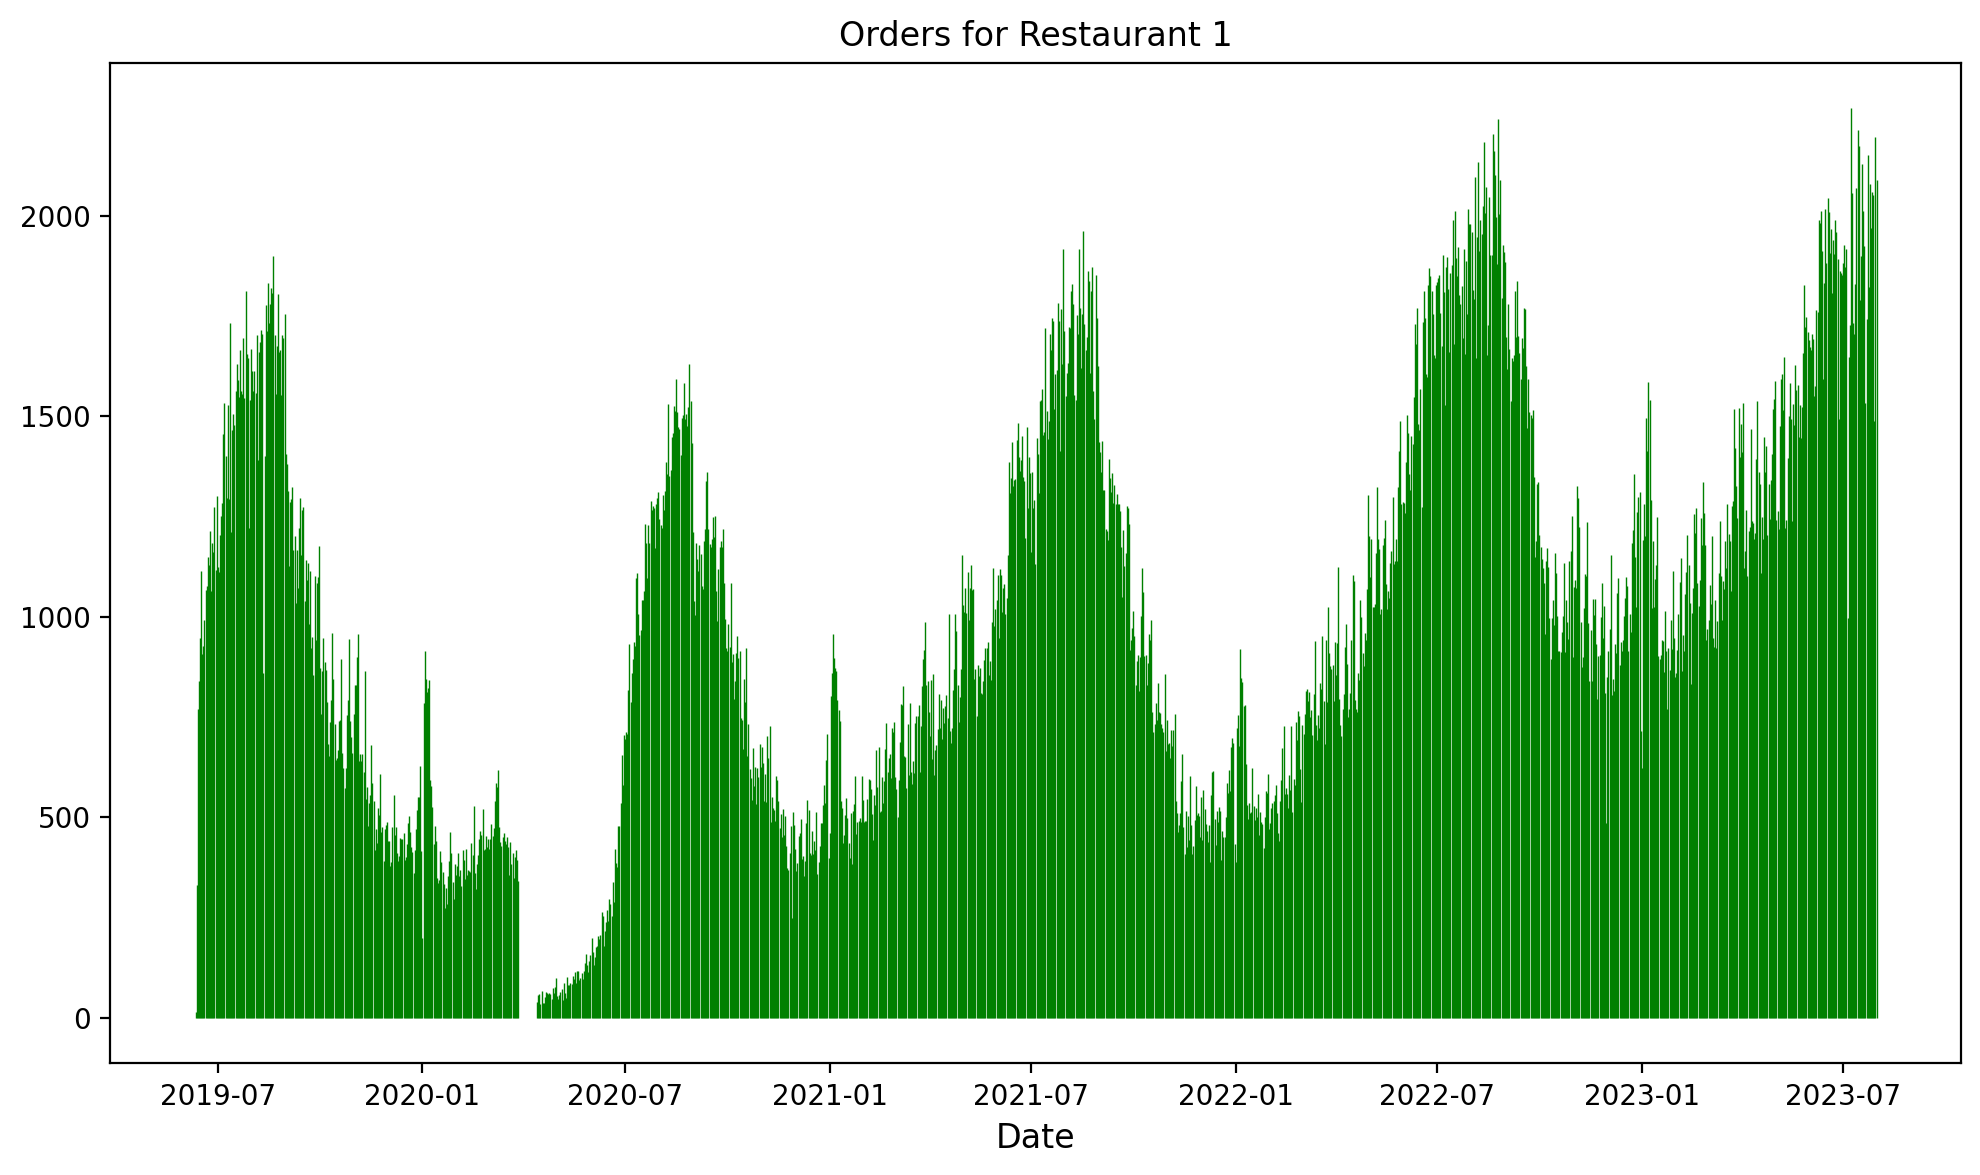

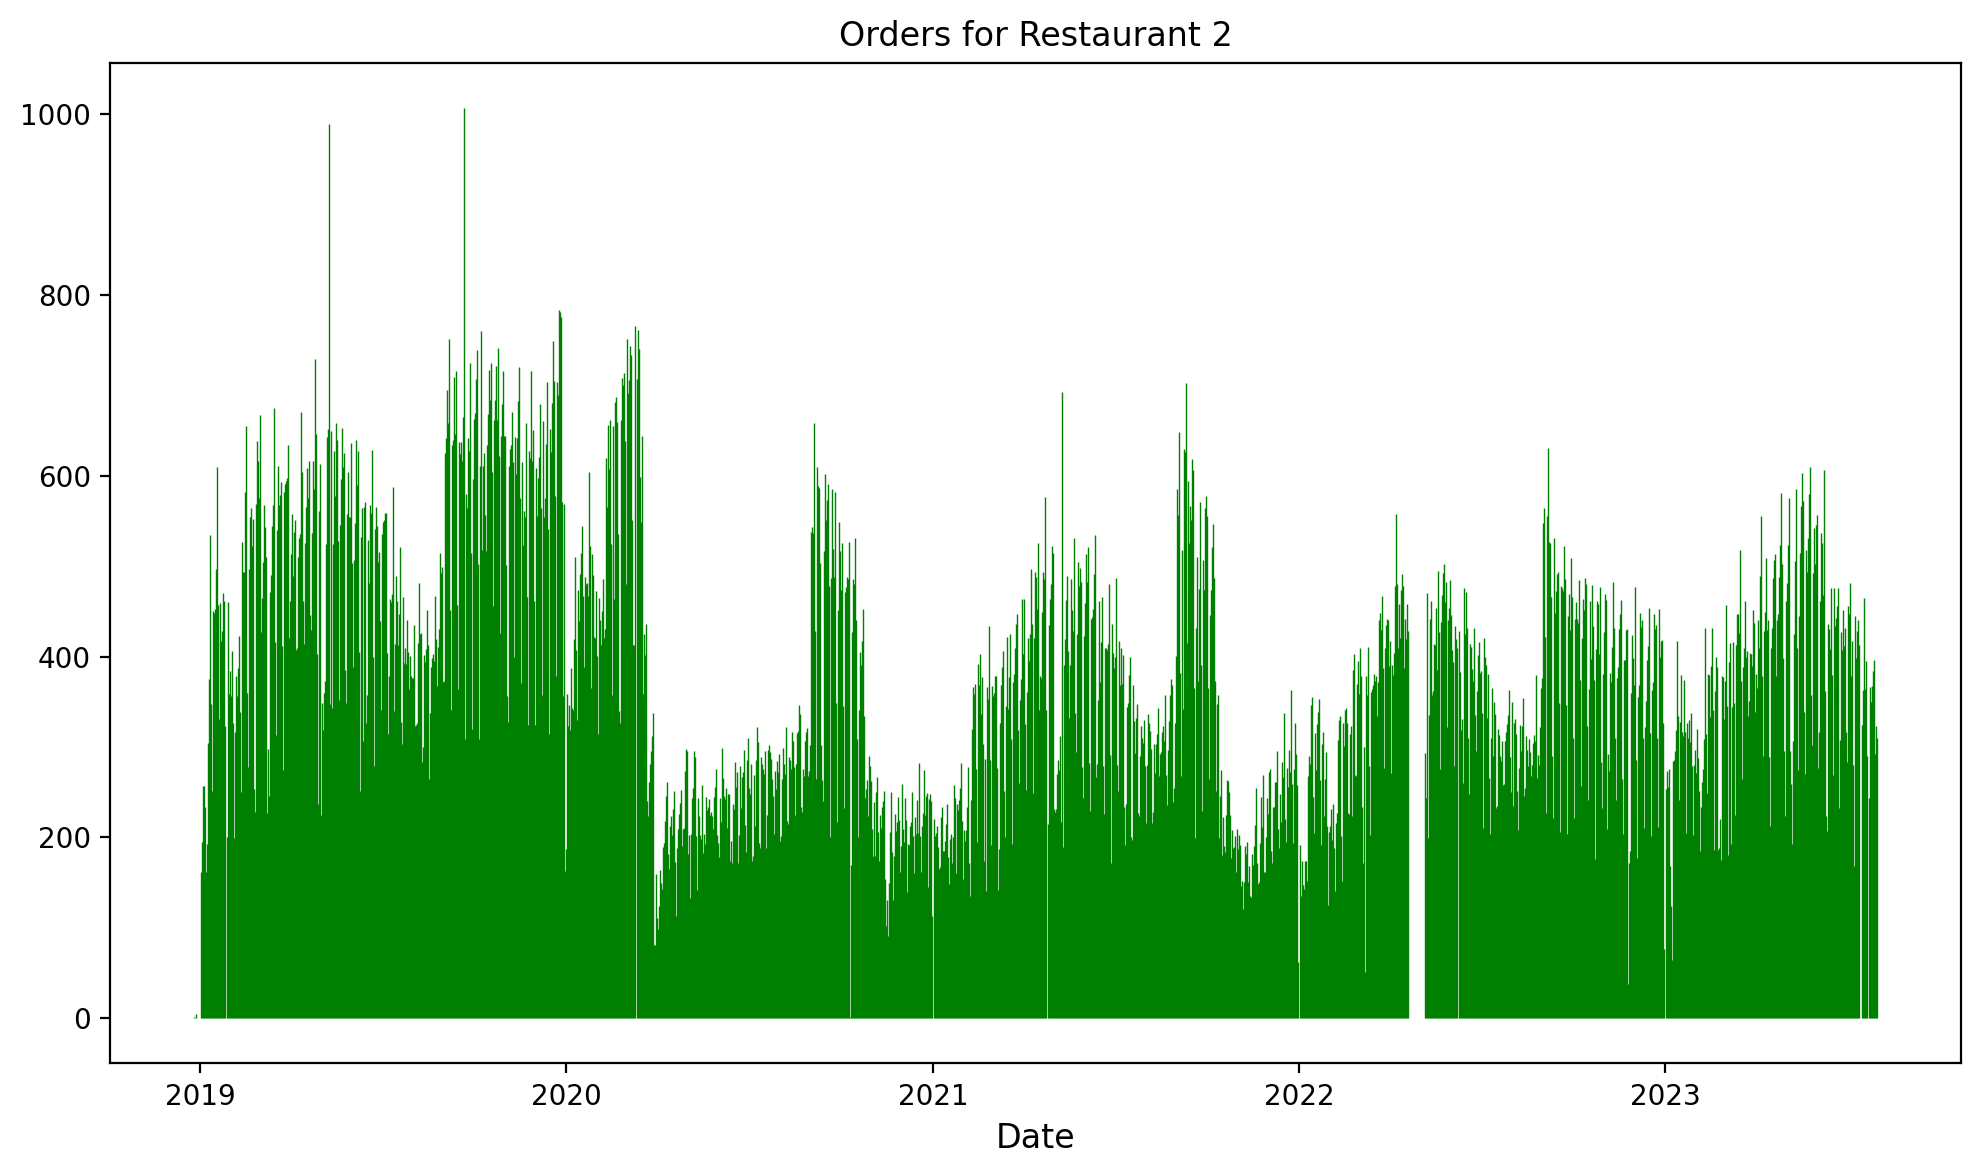

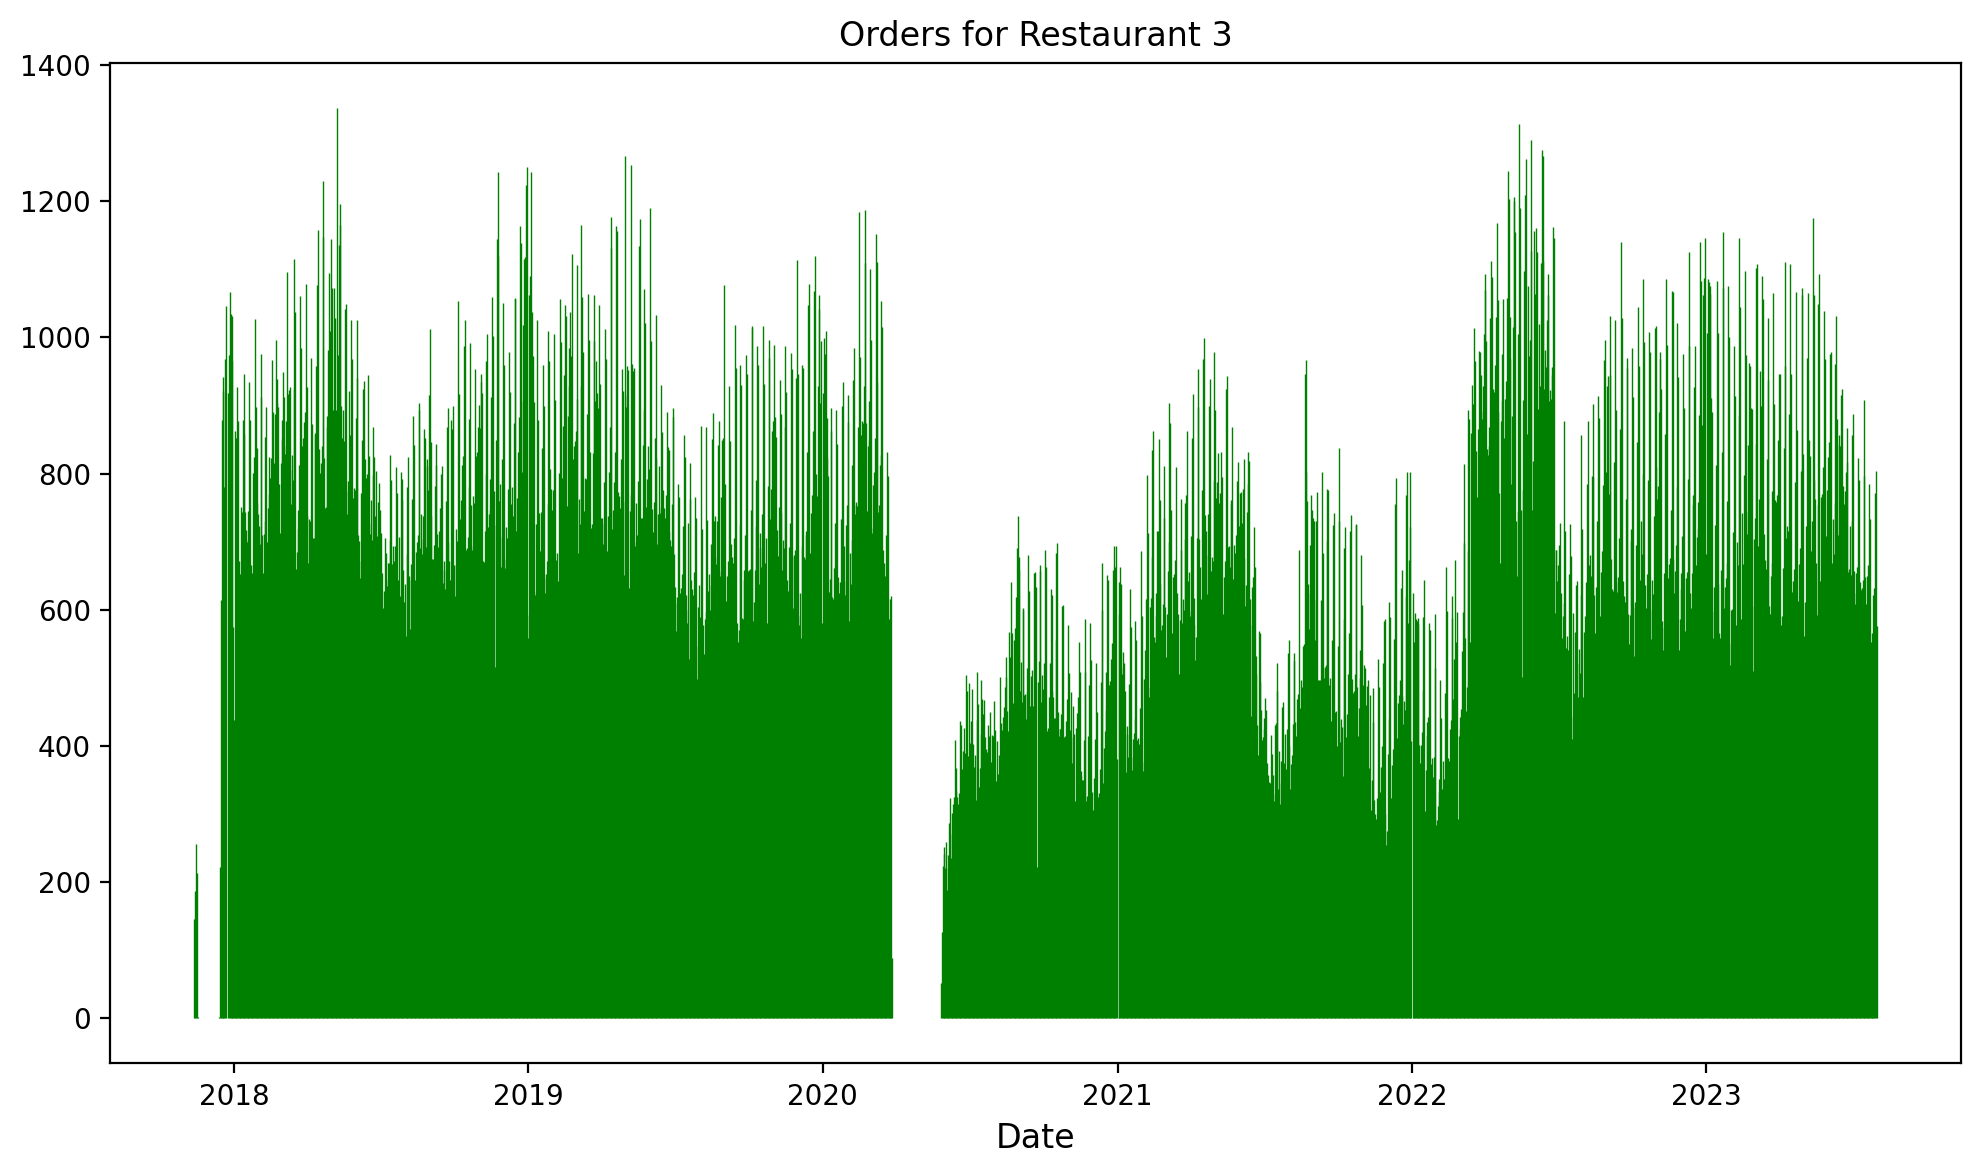

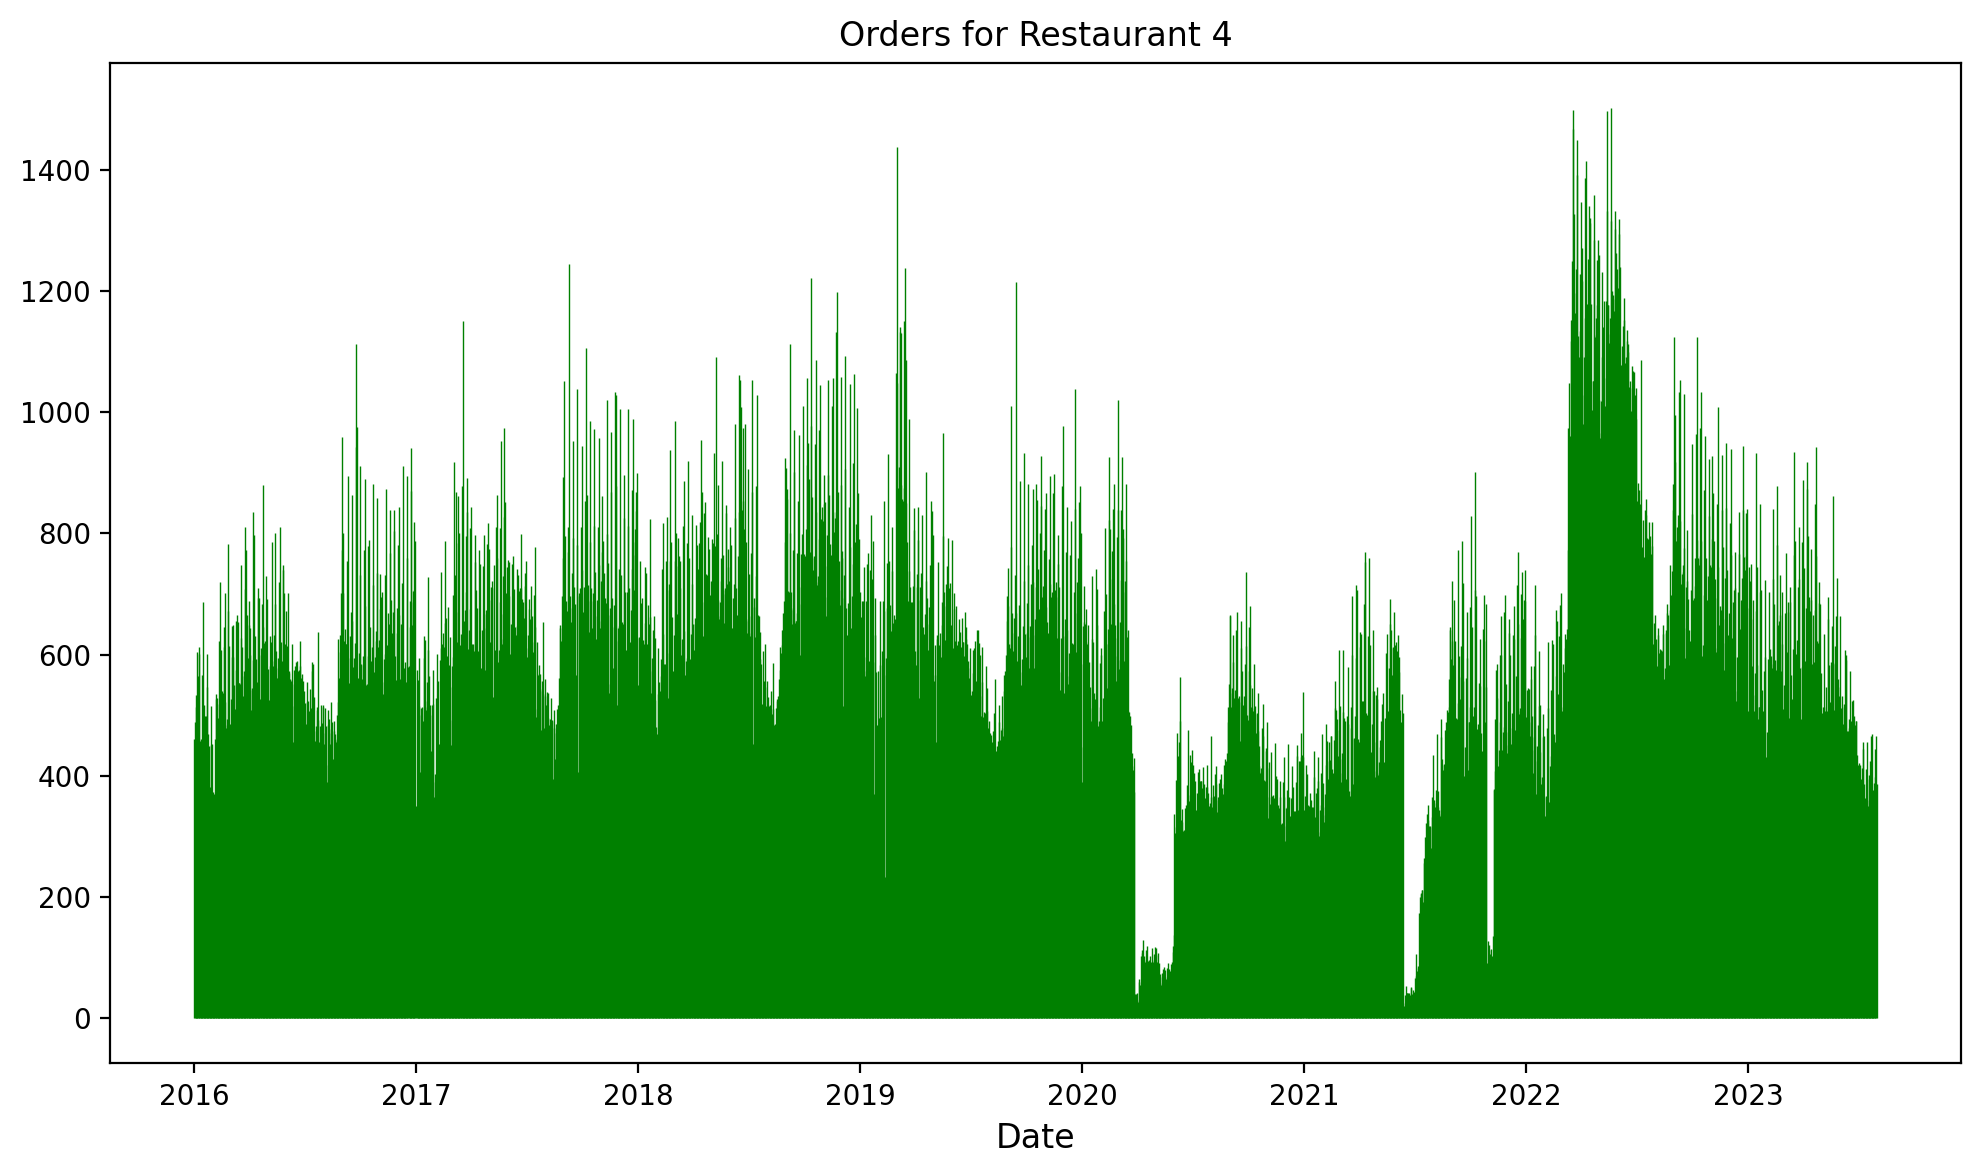

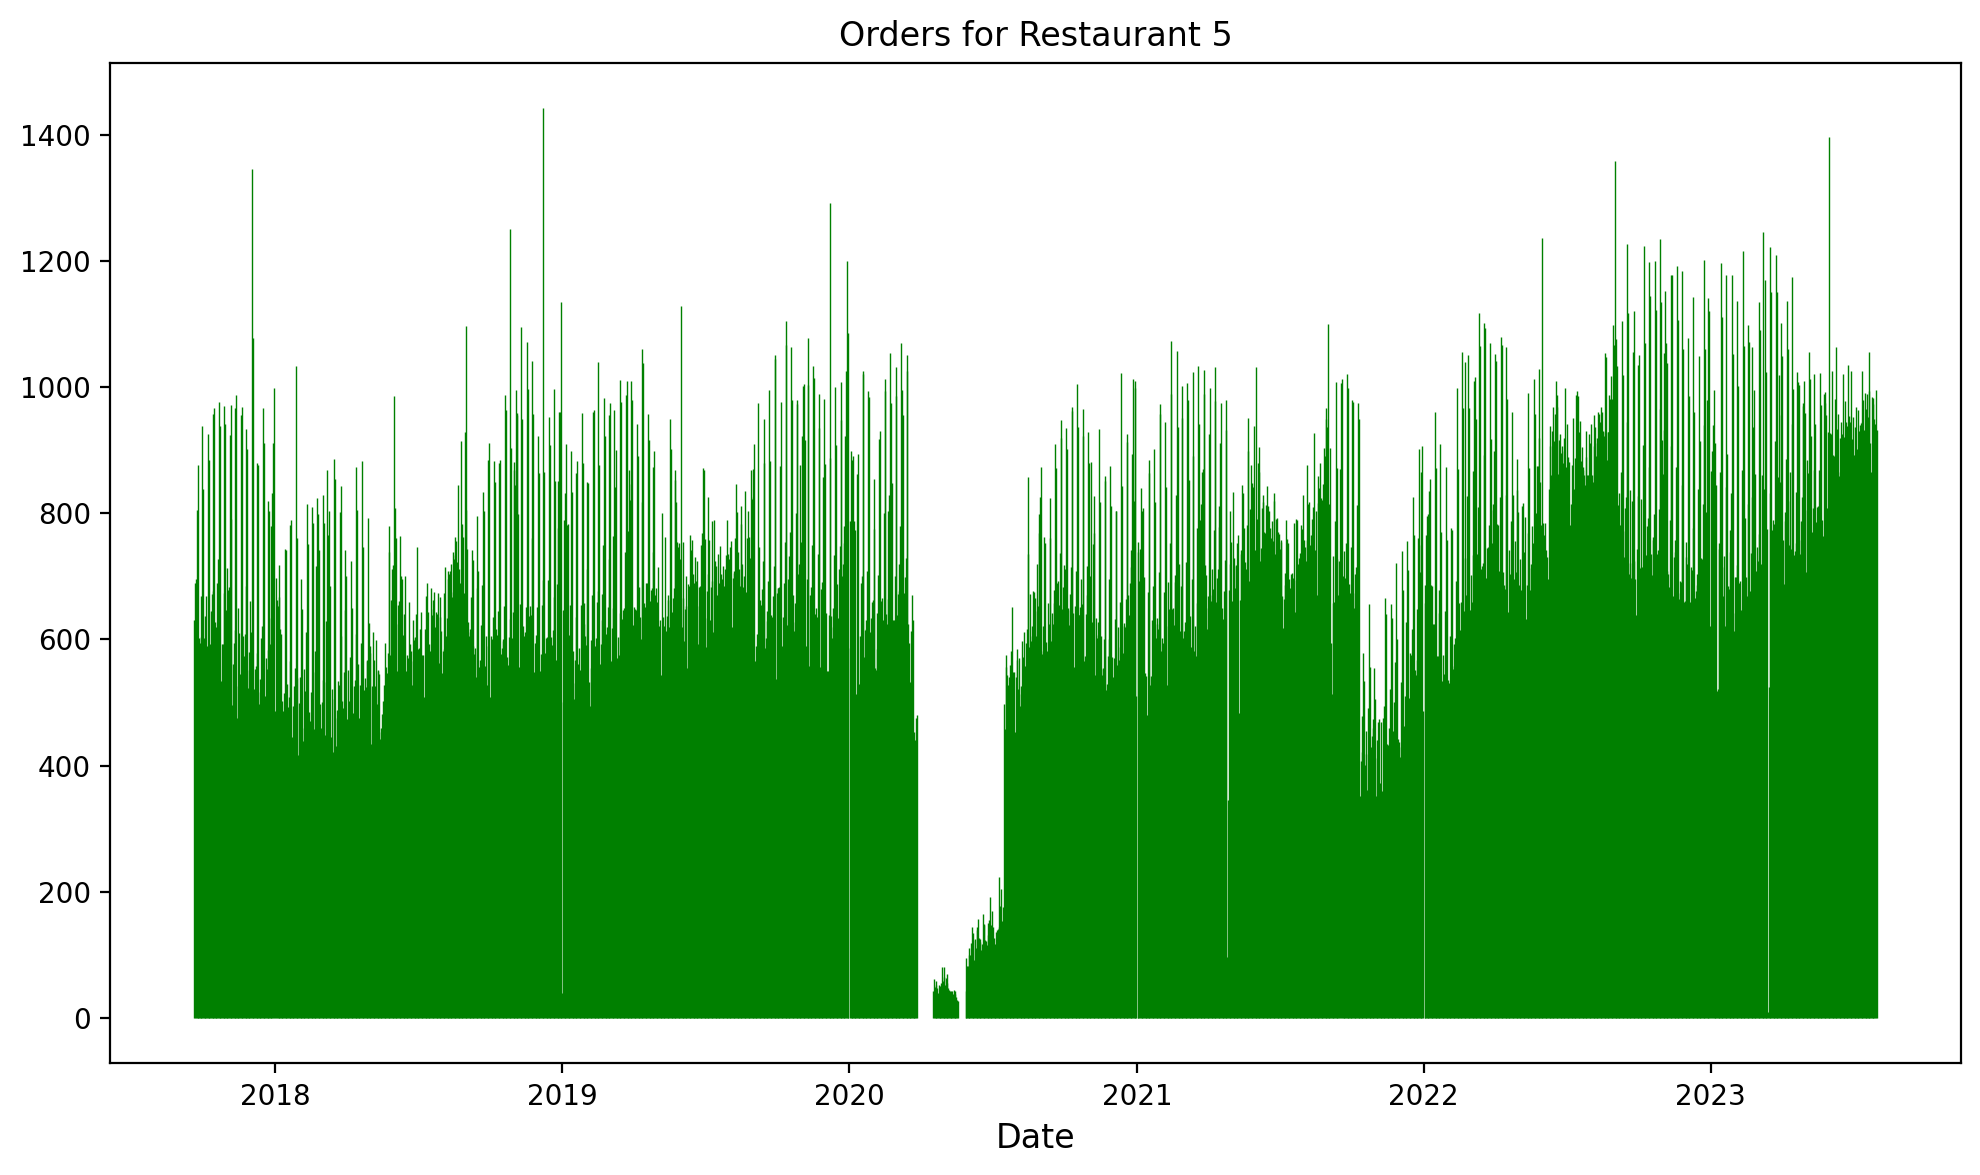

In [13]:
for i, rest_df in enumerate(rest_df_list):
    title = f" for Restaurant {i+1}"
    plot_orders(rest_df, title)

По графиками ресторанов видно, что первый ресторан сильно отличается от остальных. 

Тут отчетливно видна трендовая составляющая и цикличность.

### Проверка стационарности

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf(x, threshold=0.05):
    """
    Тест стационарности Augmented Dickey-Fuller Test(ADF Test)

    Args:
        x: Вектор значений переданный для проверки на стационарность
        threshold: Уровень достоверности, по умолчанию 5%

    Returns:
    """

    _, pvalue = adfuller(x)[0], adfuller(x)[1]

    print("Test-Statistic:", _)
    print("P-Value:", pvalue)

    # The null hypothesis of the ADF test is that the time series is non-stationary.
    H0 = "Time series is non-stationary"
    Ha = "Time series is stationary!"

    if pvalue <= threshold:  # Reject the null hypothesis
        print(Ha)
    else:
        print(H0)

In [15]:
for i, rest_df in enumerate(rest_df_list):
    print(f"Restaurant {i+1}")
    adf(rest_df['Orders'].values)
    print()

Restaurant 1
Test-Statistic: -2.2375306230207834
P-Value: 0.19290697963260356
Time series is non-stationary

Restaurant 2
Test-Statistic: -3.4284811011947043
P-Value: 0.010025433218888128
Time series is stationary!

Restaurant 3
Test-Statistic: -3.80974902015159
P-Value: 0.002809130008382792
Time series is stationary!

Restaurant 4
Test-Statistic: -4.053721146931329
P-Value: 0.0011539149093058307
Time series is stationary!

Restaurant 5
Test-Statistic: -3.0846850765652243
P-Value: 0.02770751769794391
Time series is stationary!



Статистические тесты показали, что заказы по первому ресторану не являются стационарным временным рядом, т.е. имеют тренд и сезонную компоненту

### Графики заказов для каждого ресторана за последние 200 дней

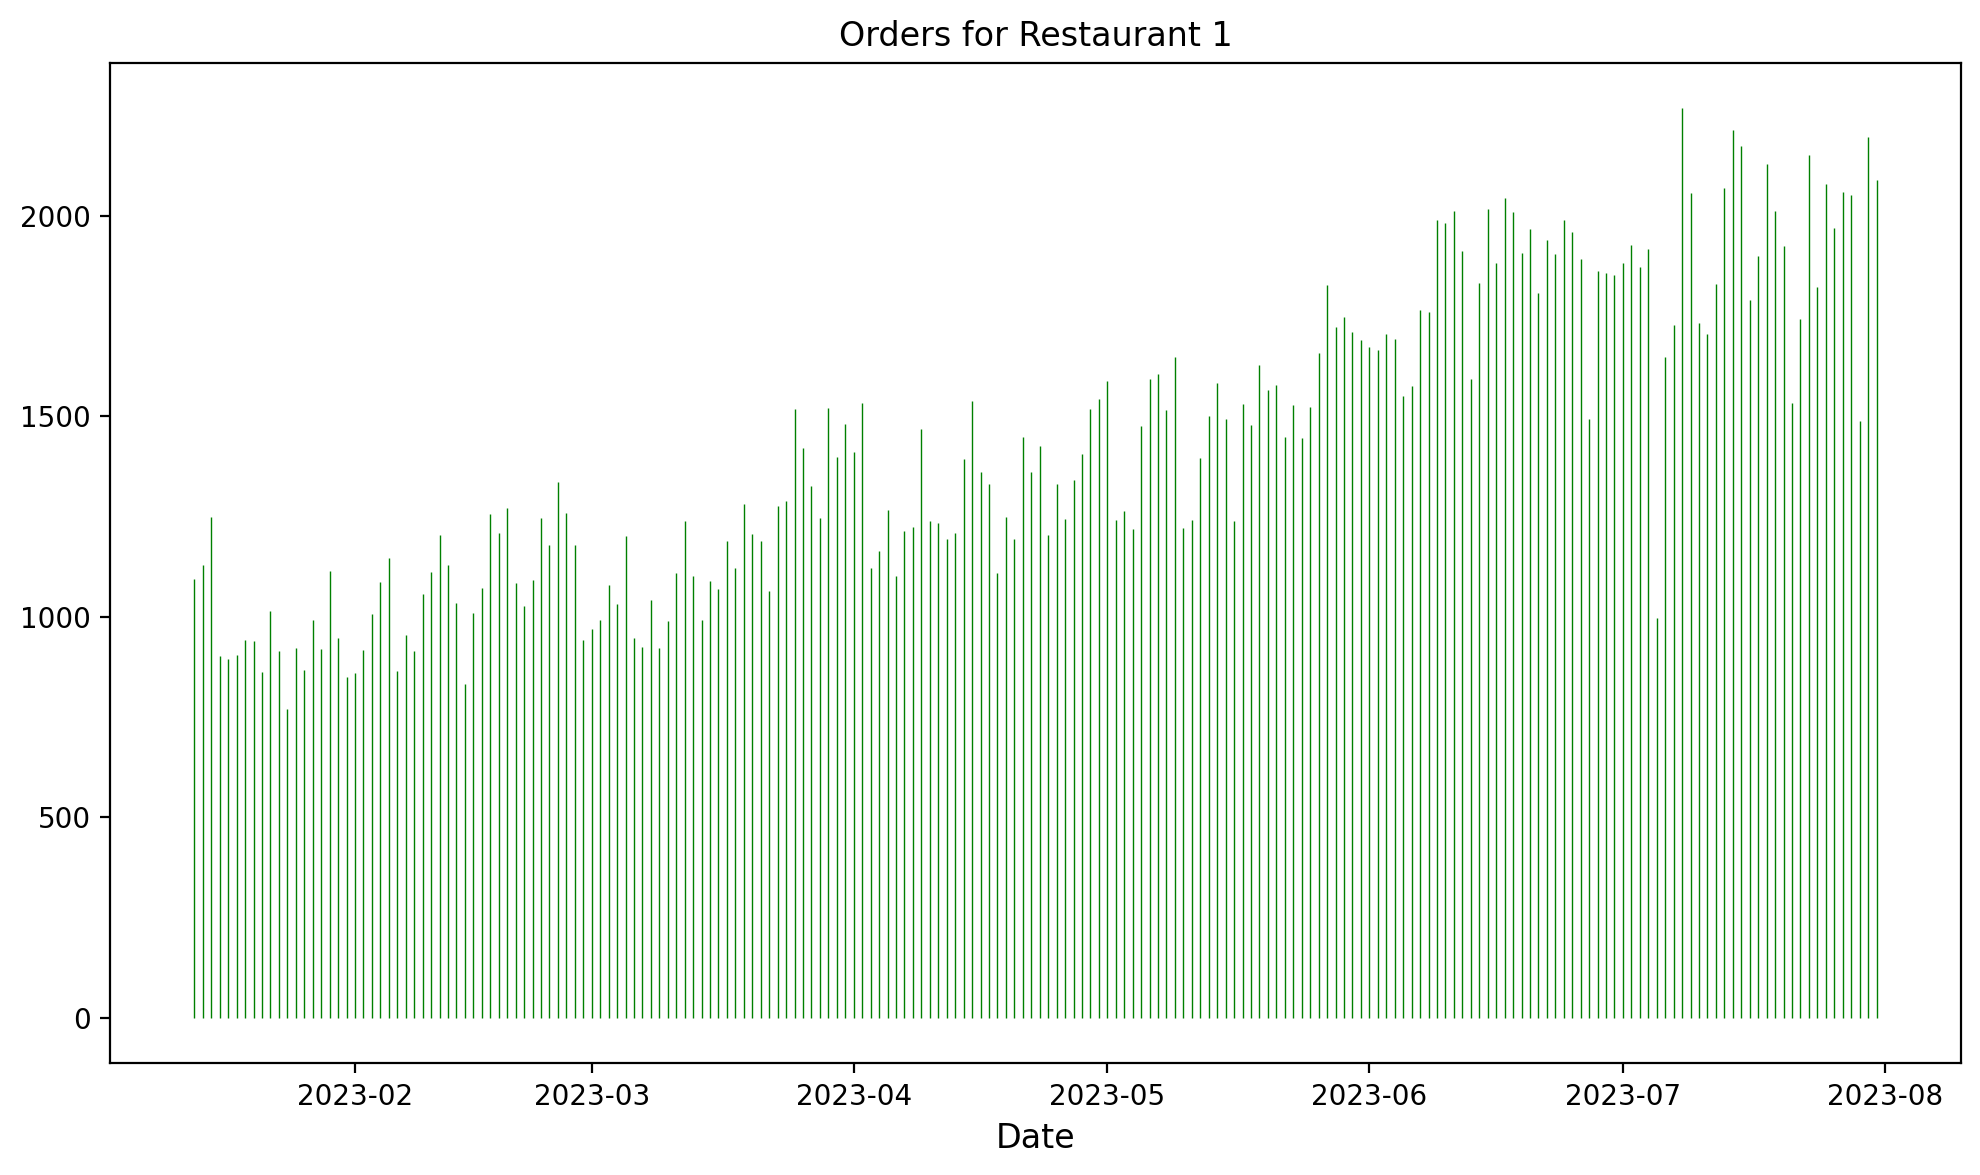

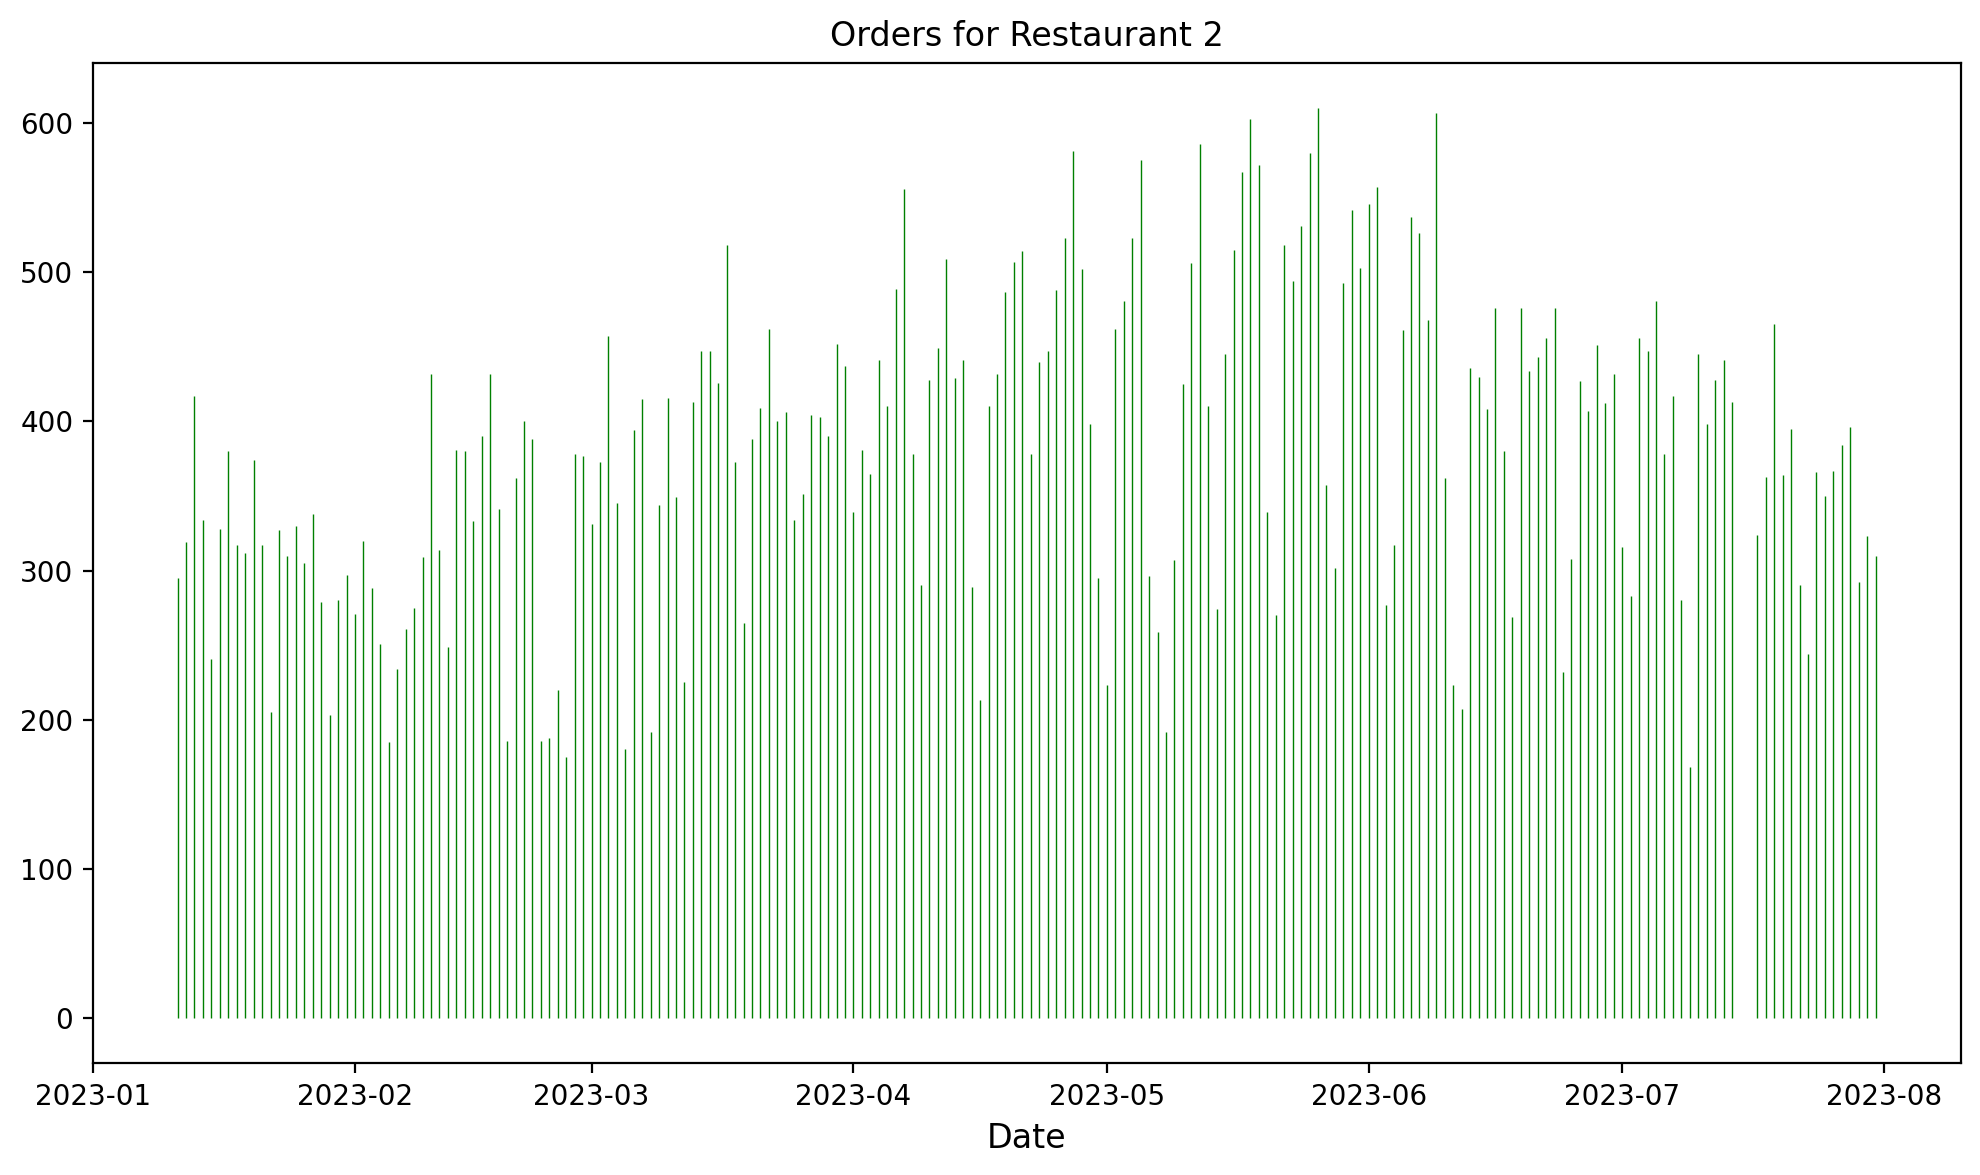

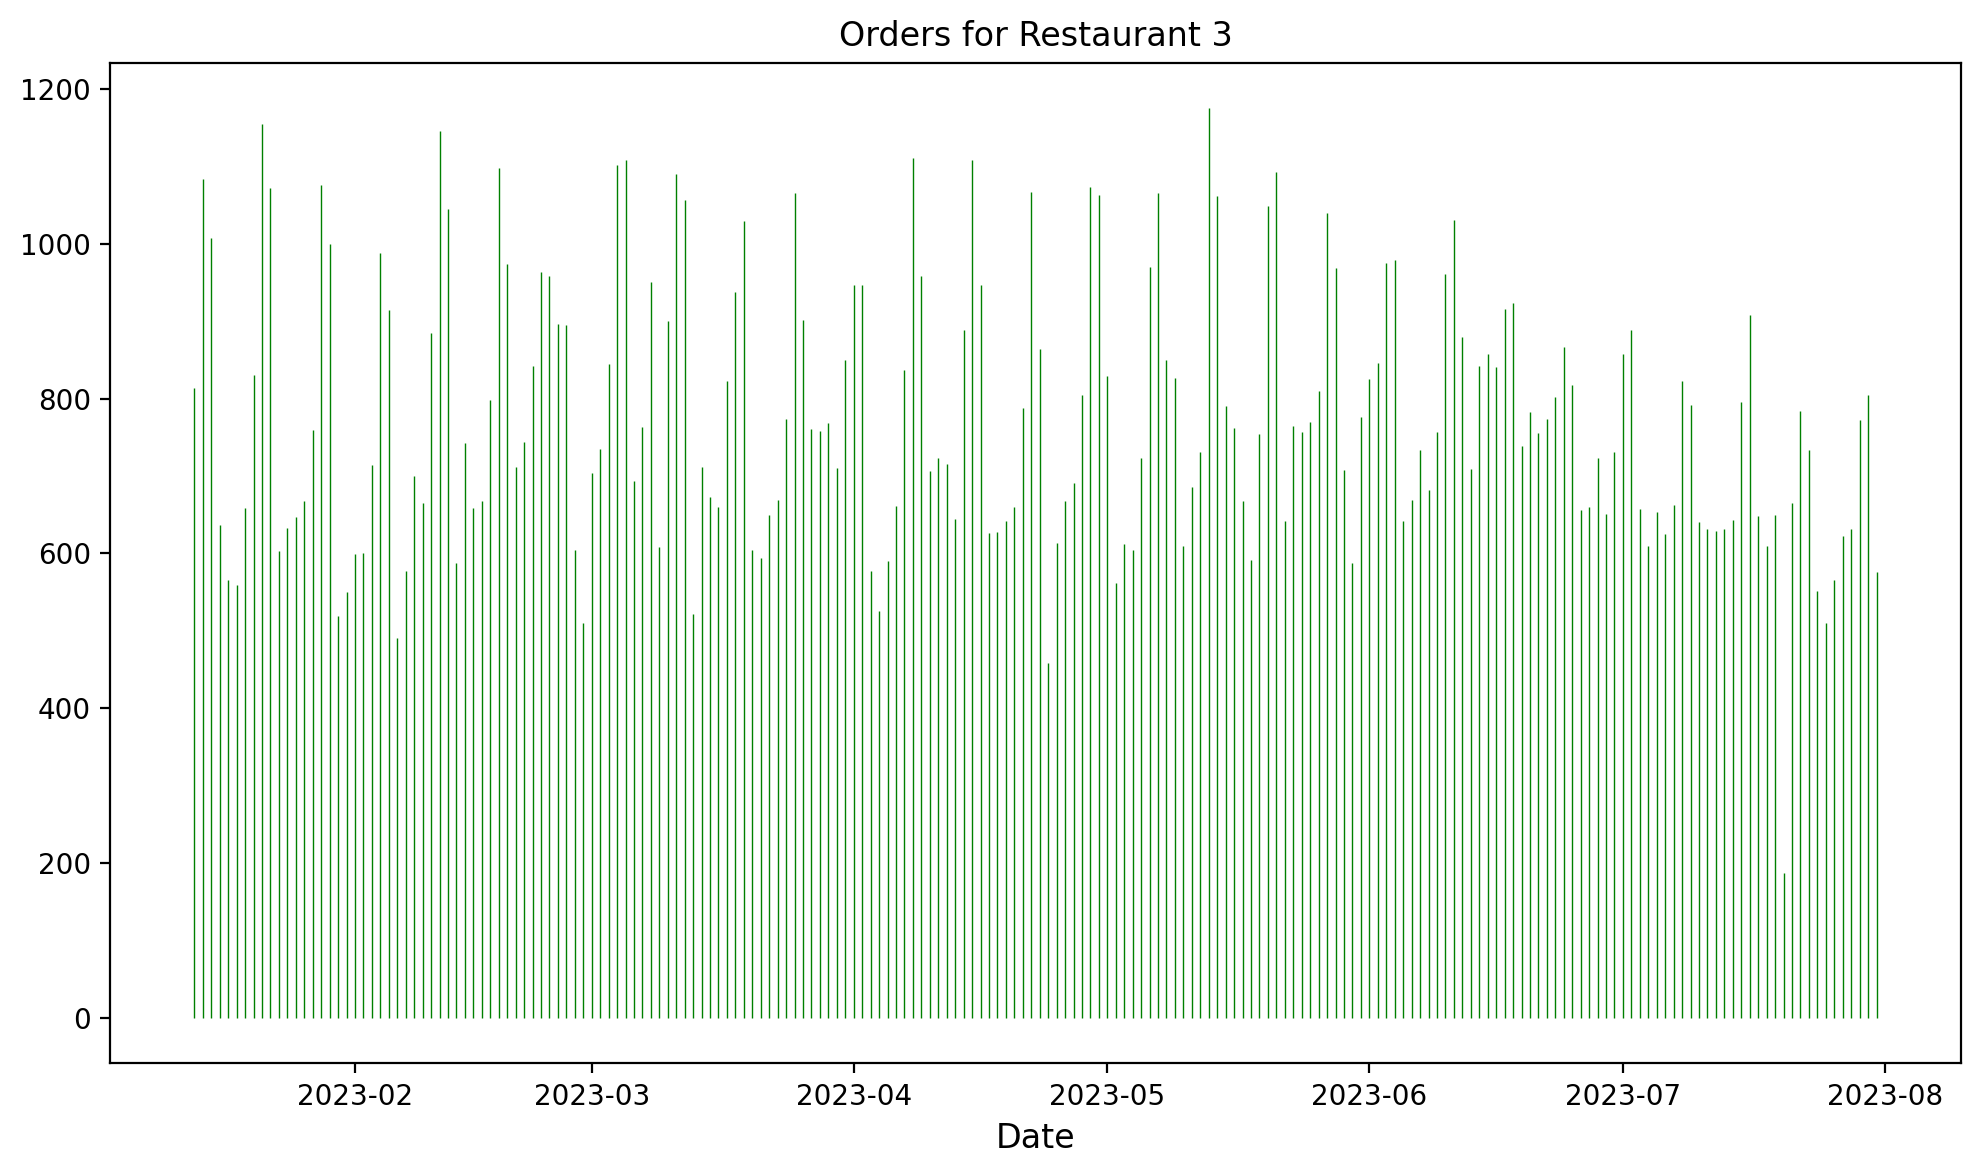

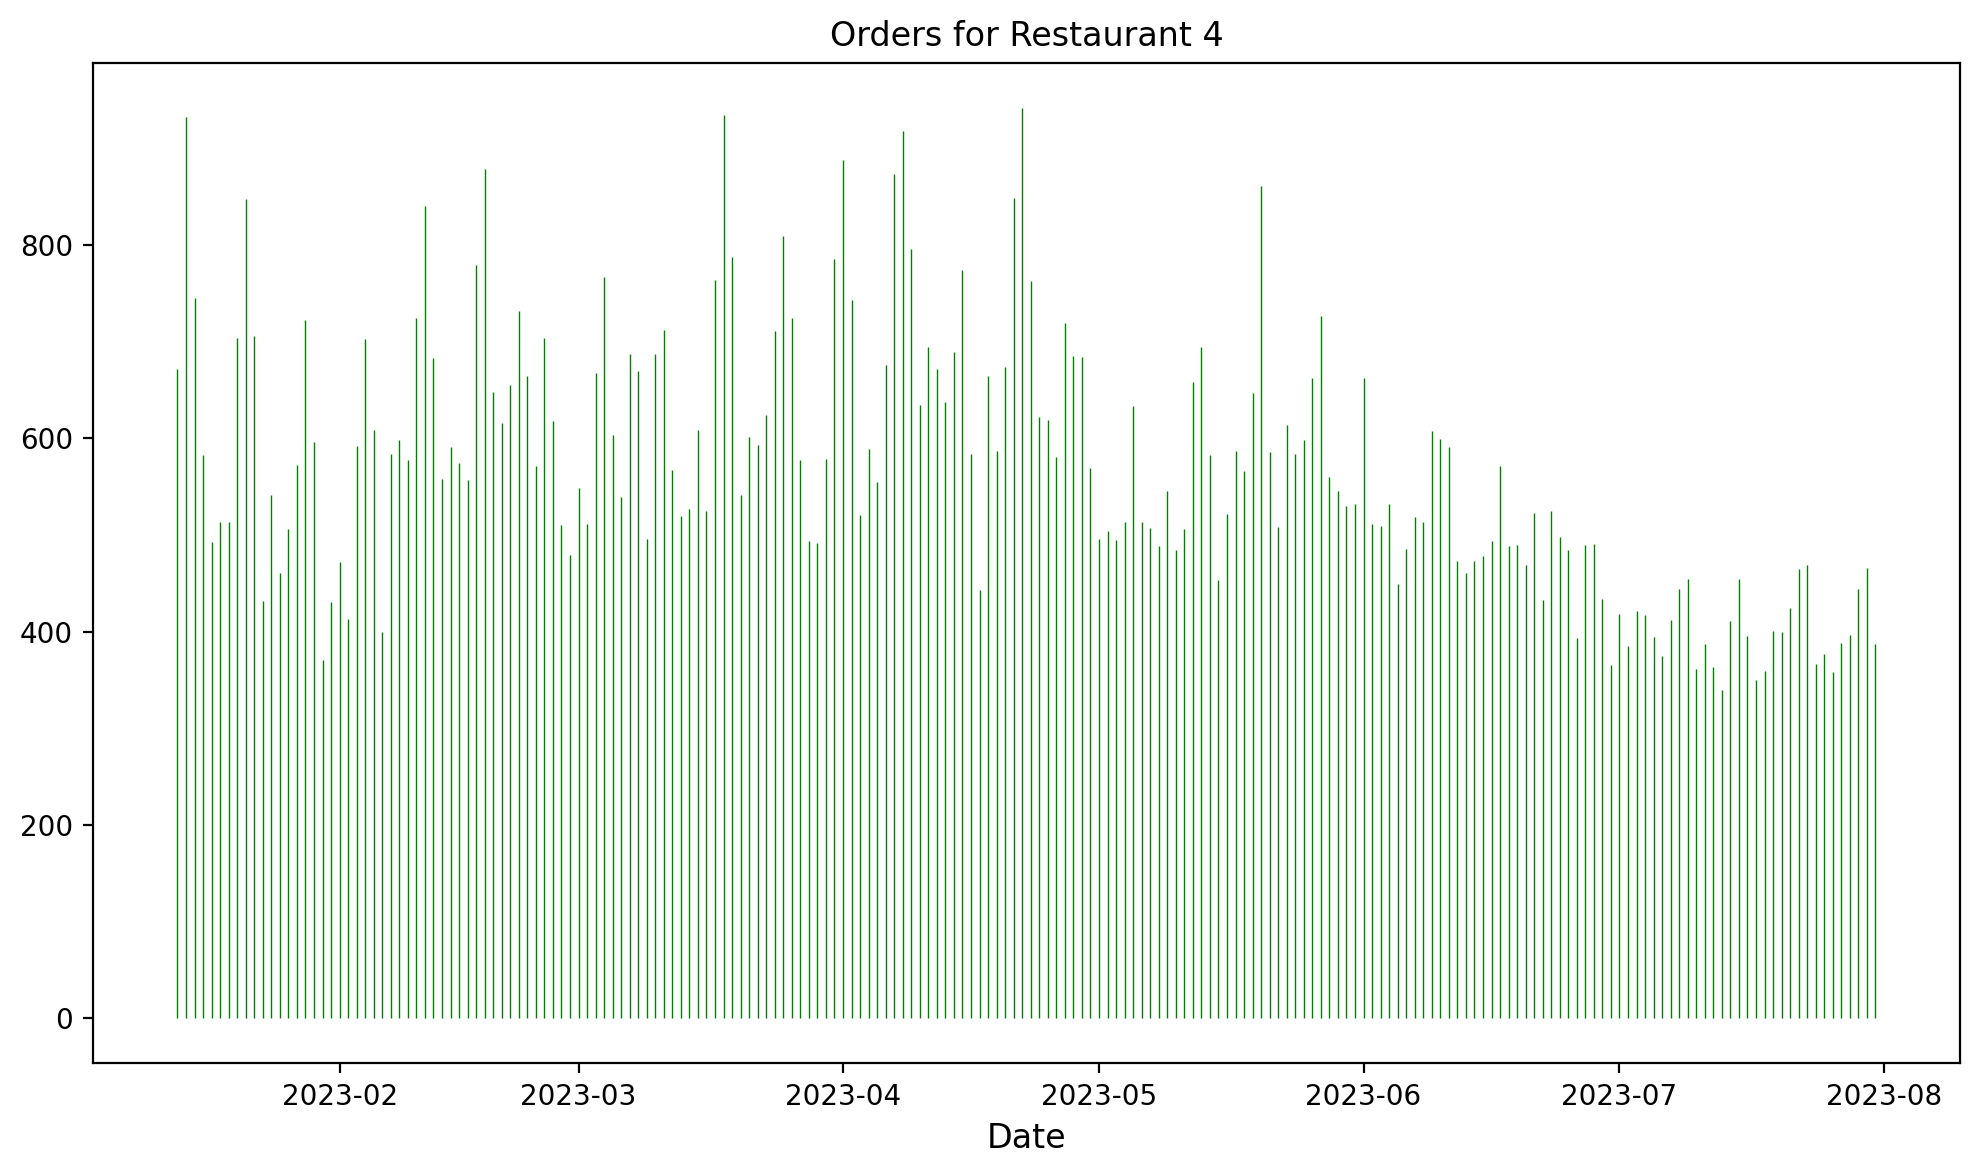

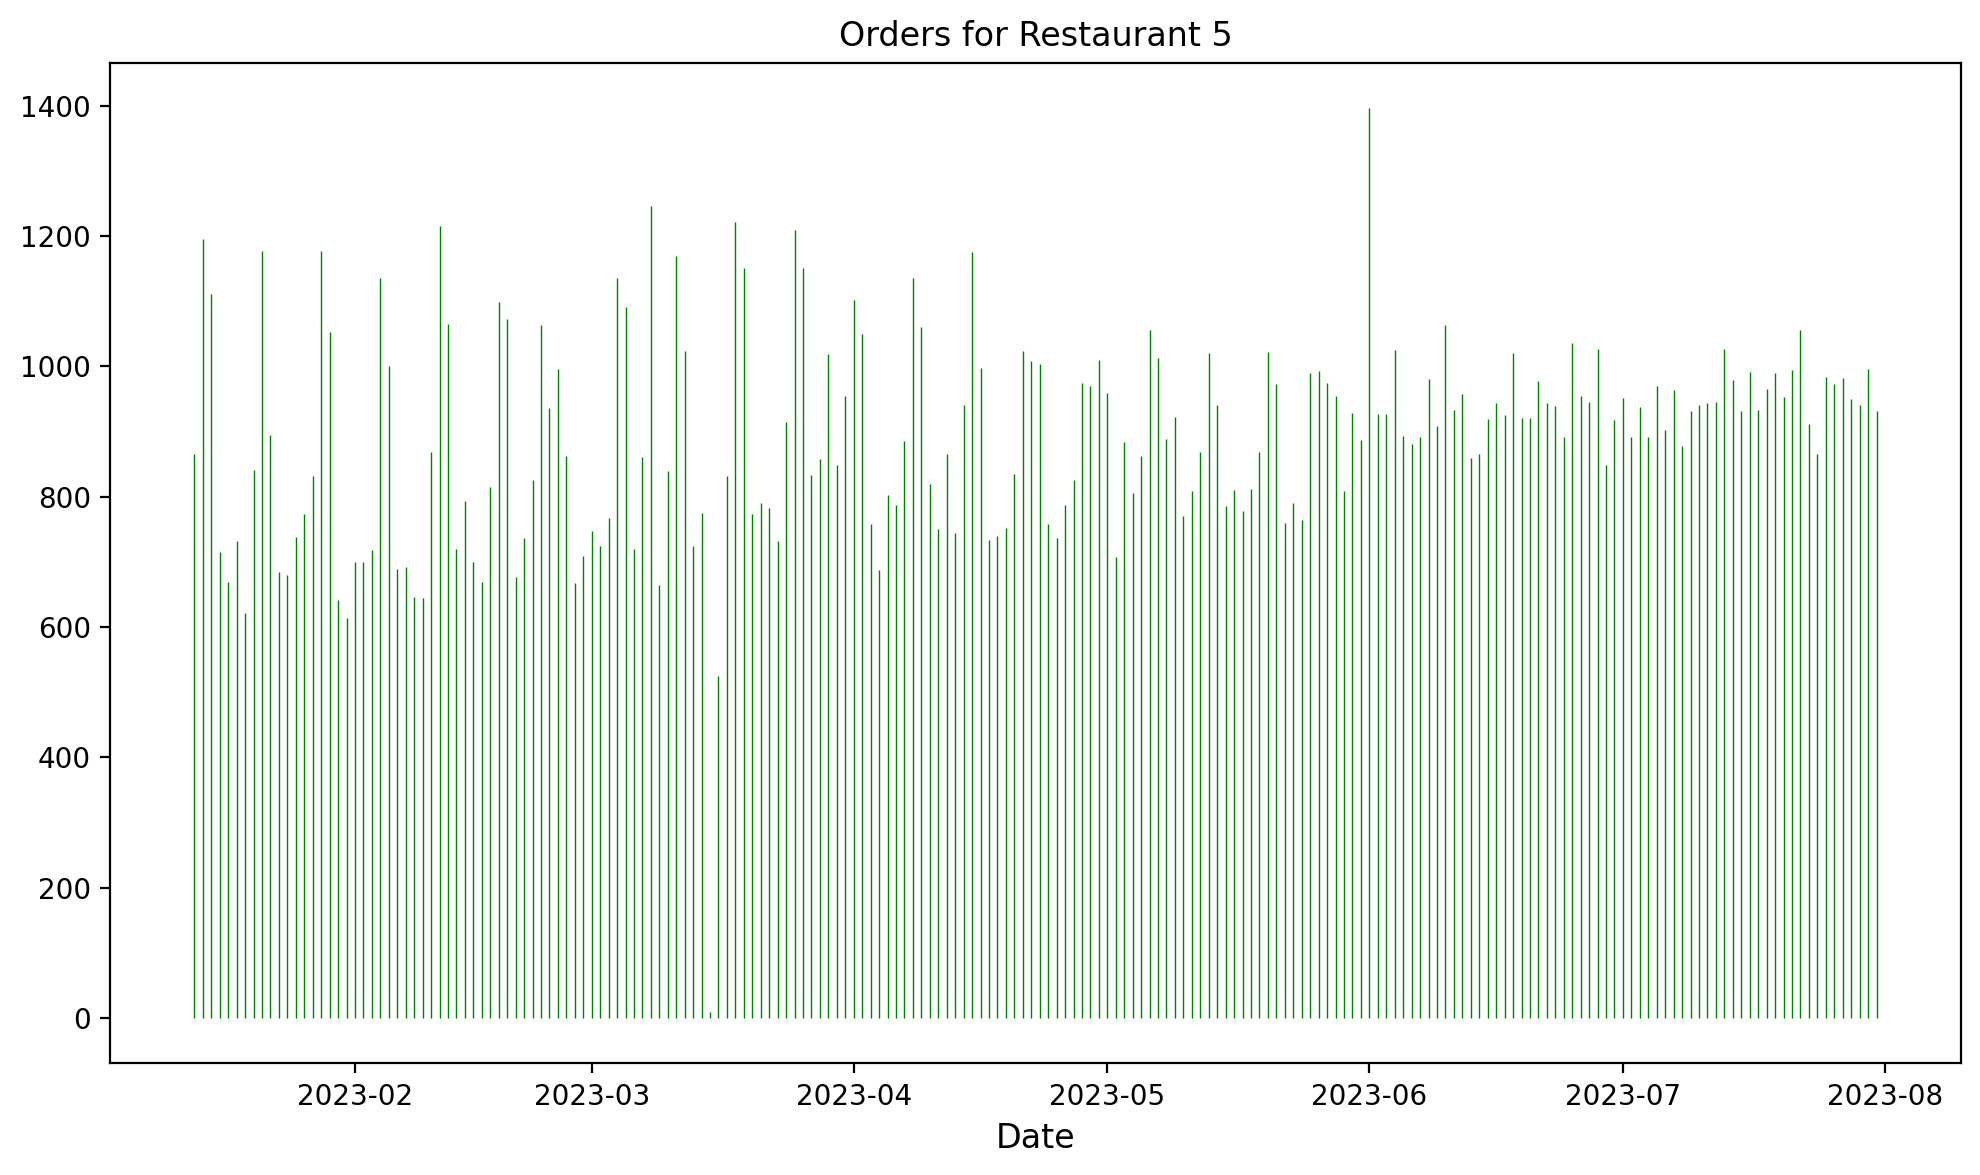

In [16]:
for i, rest_df in enumerate(rest_df_list):
    title = f" for Restaurant {i+1}"
    plot_orders(rest_df.tail(200), title)

### Работа с календарем

In [17]:
calendar = pd.read_excel('../data/BurgerKing_TimeSeries_TEST.xlsx', sheet_name='Calendar')
calendar

,day_id,week_id,month_id,year_id,day_year,day_week,day_number,week_number,month_number,quarter_number,is_holiday,is_warm,is_black_friday
0,2016-01-01,201553,201601,2016,1,5,1,53,1,1,1,0,0
1,2016-01-02,201553,201601,2016,2,6,2,53,1,1,0,0,0
2,2016-01-03,201553,201601,2016,3,7,3,53,1,1,0,0,0
3,2016-01-04,201601,201601,2016,4,1,4,1,1,1,1,0,0
4,2016-01-05,201601,201601,2016,5,2,5,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,2024-12-27,202452,202412,2024,362,5,27,52,12,4,0,0,0
3284,2024-12-28,202452,202412,2024,363,6,28,52,12,4,0,0,0
3285,2024-12-29,202452,202412,2024,364,7,29,52,12,4,0,0,0
3286,2024-12-30,202501,202412,2024,365,1,30,1,12,4,1,0,0


In [18]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   day_id           3288 non-null   datetime64[ns]
 1   week_id          3288 non-null   int64         
 2   month_id         3288 non-null   int64         
 3   year_id          3288 non-null   int64         
 4   day_year         3288 non-null   int64         
 5   day_week         3288 non-null   int64         
 6   day_number       3288 non-null   int64         
 7   week_number      3288 non-null   int64         
 8   month_number     3288 non-null   int64         
 9   quarter_number   3288 non-null   int64         
 10  is_holiday       3288 non-null   int64         
 11  is_warm          3288 non-null   int64         
 12  is_black_friday  3288 non-null   int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 334.1 KB
